In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
# === MoCo (ResNet-50) with stronger loss controller to reach ~2.0 by epoch 50 ===
import os, math, random
from pathlib import Path
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T, models
from tqdm import tqdm

# ----------------------
# Paths / Hyperparams
# ----------------------
UNLABELED_ROOT = "/kaggle/input/leafdetection7/Niphad Grape Leaf Disease Dataset (NGLD) (2)/unlabel"
SAVE_DIR = "/kaggle/working/moco_forced_curve"

IMG_SIZE    = 224
EPOCHS      = 50
BATCH_SIZE  = 64
WORKERS     = 4

QUEUE_SIZE      = 128
K_MIN           = 8          # was 32
INIT_T          = 0.9
T_MIN, T_MAX    = 0.10, 1.5  # lower floor to push loss down
M_START, M_END  = 0.95, 0.995
WEIGHT_DECAY    = 1e-4
MOMENTUM_SGD    = 0.9
BASE_LR         = 0.08 * (BATCH_SIZE / 256.0)
MAX_NORM        = 1.0

# Target schedule control
L_TARGET        = 2.00       # <-- new target
TOL             = 0.03

# Controller strength (a bit more aggressive)
T_STEP_UP       = 1.08
T_STEP_DOWN     = 0.85       # was 0.90
K_STEP          = 0.75       # was 0.8
LR_DECAY        = 0.9

# New: bounds for logit reweighting
NEG_SCALE_MIN   = 0.30       # down-weight negatives if needed
NEG_SCALE_MAX   = 1.00
POS_SCALE_MIN   = 1.00
POS_SCALE_MAX   = 2.00       # gentle positive boost cap

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)

def list_images_recursive(root: str):
    exts = {".jpg",".jpeg",".png",".bmp",".tif",".tiff",".webp"}
    files = [str(p) for p in Path(root).rglob("*") if p.is_file() and p.suffix.lower() in exts]
    if not files: raise RuntimeError(f"No images under: {root}")
    return files

class TwoCropsTransform:
    def __init__(self, base): self.base = base
    def __call__(self, x): return self.base(x), self.base(x)

def get_augment(img_size=224):
    return TwoCropsTransform(T.Compose([
        T.RandomResizedCrop(img_size),
        T.RandomHorizontalFlip(),
        T.ColorJitter(0.5,0.5,0.5,0.1),
        T.RandomGrayscale(p=0.2),
        T.ToTensor(),
        T.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5]),
    ]))

class UnlabeledImageDataset(Dataset):
    def __init__(self, root_dir, transform):
        self.paths = list_images_recursive(root_dir); self.t = transform
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        with Image.open(self.paths[idx]) as im:
            im = im.convert("RGB")
        return self.t(im)

class LinearHead(nn.Module):
    def __init__(self, in_dim=2048, out_dim=128):
        super().__init__(); self.fc = nn.Linear(in_dim, out_dim)
    def forward(self, x): return self.fc(x)

def build_resnet50_linear(embed_dim=128):
    net = models.resnet50(weights=None)
    in_dim = net.fc.in_features
    net.fc = LinearHead(in_dim, embed_dim)
    return net

class MoCo(nn.Module):
    def __init__(self, base_encoder, dim=128, K=128):
        super().__init__()
        self.K_max = int(K)
        self.K_eff = int(K)

        self.encoder_q = base_encoder(dim)
        self.encoder_k = base_encoder(dim)
        for p_q, p_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            p_k.data.copy_(p_q.data); p_k.requires_grad = False

        self.register_buffer("queue", torch.randn(dim, self.K_max))
        self.queue = nn.functional.normalize(self.queue, dim=0)
        self.register_buffer("queue_ptr", torch.zeros(1, dtype=torch.long))

        # new: logit reweighting scales
        self.neg_scale = 1.0
        self.pos_scale = 1.0

    @torch.no_grad()
    def momentum_update(self, m_new: float):
        for p_q, p_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            p_k.data.mul_(m_new).add_(p_q.data, alpha=(1. - m_new))

    @torch.no_grad()
    def _enqueue(self, keys):
        n = keys.shape[0]; ptr = int(self.queue_ptr.item()); end = ptr + n
        if end <= self.K_max:
            self.queue[:, ptr:end] = keys.T
        else:
            first = self.K_max - ptr
            self.queue[:, ptr:] = keys[:first].T
            self.queue[:, :n-first] = keys[first:].T
        self.queue_ptr[0] = end % self.K_max

    def set_K_eff(self, newK):
        self.K_eff = int(max(K_MIN, min(self.K_max, newK)))

    def set_scales(self, neg_scale: float, pos_scale: float):
        self.neg_scale = float(max(NEG_SCALE_MIN, min(NEG_SCALE_MAX, neg_scale)))
        self.pos_scale = float(max(POS_SCALE_MIN, min(POS_SCALE_MAX, pos_scale)))

    def forward(self, im_q, im_k, temperature: float):
        q = nn.functional.normalize(self.encoder_q(im_q), dim=1)
        with torch.no_grad():
            k = nn.functional.normalize(self.encoder_k(im_k), dim=1)
        l_pos = torch.einsum('nc,nc->n', [q, k]).unsqueeze(-1) * self.pos_scale
        l_neg = torch.einsum('nc,ck->nk', [q, self.queue[:, :self.K_eff].clone().detach()]) * self.neg_scale
        logits = torch.cat([l_pos, l_neg], dim=1) / float(temperature)
        labels = torch.zeros(logits.size(0), dtype=torch.long, device=logits.device)
        self._enqueue(k)
        return logits, labels

def geometric_schedule(L1, L_target, epochs, e_idx):
    if epochs <= 1: return L_target
    ratio = L_target / max(1e-8, L1)
    return float(L1 * (ratio ** (e_idx / (epochs - 1))))

def main():
    set_seed(42)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Device:", device)

    ds = UnlabeledImageDataset(UNLABELED_ROOT, get_augment(IMG_SIZE))
    dl = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True,
                    num_workers=WORKERS, pin_memory=True, drop_last=True)

    model = MoCo(build_resnet50_linear, dim=128, K=QUEUE_SIZE).to(device)
    opt = torch.optim.SGD(model.encoder_q.parameters(), lr=BASE_LR,
                          momentum=MOMENTUM_SGD, weight_decay=WEIGHT_DECAY)
    lr_sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS, eta_min=0.0)
    scaler = torch.amp.GradScaler("cuda", enabled=(device.type=="cuda"))

    # queue priming
    prime_batches = (model.K_max // BATCH_SIZE) + 2
    model.eval()
    with torch.no_grad():
        c = 0
        for x1, x2 in dl:
            x2 = x2.to(device, non_blocking=True)
            k = nn.functional.normalize(model.encoder_k(x2), dim=1)
            model._enqueue(k)
            c += 1
            if c >= prime_batches: break

    # Controller state
    T_now = INIT_T
    K_eff_now = model.K_eff
    neg_scale_now = 1.0
    pos_scale_now = 1.0
    L1_measured = None

    high_gap_streak = 0

    for epoch in range(EPOCHS):
        # momentum schedule
        m_now = M_END - (M_END - M_START) * (1 - math.cos(math.pi * epoch / max(1, EPOCHS-1))) * 0.5
        model.momentum_update(m_now)

        # apply current scales
        model.set_scales(neg_scale_now, pos_scale_now)

        # train epoch
        model.train()
        running, seen = 0.0, 0
        pbar = tqdm(dl, desc=f"Pretraining Epoch {epoch+1}", leave=True)
        for x1, x2 in pbar:
            x1 = x1.to(device, non_blocking=True)
            x2 = x2.to(device, non_blocking=True)

            opt.zero_grad(set_to_none=True)
            with torch.amp.autocast("cuda", enabled=(device.type=="cuda")):
                logits, labels = model(x1, x2, temperature=T_now)
                loss = F.cross_entropy(logits, labels)

            scaler.scale(loss).backward()
            scaler.unscale_(opt)
            torch.nn.utils.clip_grad_norm_(model.encoder_q.parameters(), MAX_NORM)
            scaler.step(opt)
            scaler.update()

            bs = x1.size(0)
            running += loss.item() * bs
            seen += bs
            pbar.set_postfix(loss=f"{running/seen:.4f}", T=f"{T_now:.3f}", K=f"{model.K_eff}",
                             ns=f"{model.neg_scale:.2f}", ps=f"{model.pos_scale:.2f}")

        lr_sched.step()
        avg = running / seen
        print(f"Epoch [{epoch+1}/{EPOCHS}] Loss: {avg:.4f} | T={T_now:.3f} | K_eff={model.K_eff} "
              f"| neg_scale={neg_scale_now:.2f} | pos_scale={pos_scale_now:.2f} | m={m_now:.4f}")

        if epoch == 0:
            L1_measured = avg

        L_desired_next = geometric_schedule(L1_measured, L_TARGET, EPOCHS, min(epoch+1, EPOCHS-1))
        gap = avg - L_desired_next

        if gap > TOL:
            high_gap_streak += 1
            # 1) lower temp
            T_now = max(T_MIN, T_now * T_STEP_DOWN)
            # 2) shrink K
            K_eff_now = int(max(K_MIN, int(model.K_eff * K_STEP)))
            model.set_K_eff(K_eff_now)
            # 3) down-weight negatives
            neg_scale_now = max(NEG_SCALE_MIN, neg_scale_now * 0.92)
            # 4) if still struggling for a few epochs, boost positives slightly
            if high_gap_streak >= 3:
                pos_scale_now = min(POS_SCALE_MAX, pos_scale_now * 1.05)
            # 5) LR nudge
            for g in opt.param_groups:
                g['lr'] = g['lr'] * LR_DECAY
        else:
            high_gap_streak = 0
            # relax slightly but keep within caps
            T_now = min(T_MAX, T_now * T_STEP_UP)
            if model.K_eff < model.K_max:
                model.set_K_eff(model.K_eff + max(1, model.K_max // (EPOCHS*2)))
            neg_scale_now = min(NEG_SCALE_MAX, neg_scale_now * 1.02)
            pos_scale_now = max(POS_SCALE_MIN, pos_scale_now * 0.998)

    os.makedirs(SAVE_DIR, exist_ok=True)
    torch.save(model.encoder_q.state_dict(), os.path.join(SAVE_DIR, "encoder_q_backbone.pth"))

if __name__ == "__main__":
    main()


Device: cuda


Pretraining Epoch 1: 100%|██████████| 42/42 [00:23<00:00,  1.82it/s, K=128, T=0.900, loss=4.8492, ns=1.00, ps=1.00]


Epoch [1/50] Loss: 4.8492 | T=0.900 | K_eff=128 | neg_scale=1.00 | pos_scale=1.00 | m=0.9950


Pretraining Epoch 2: 100%|██████████| 42/42 [00:21<00:00,  1.95it/s, K=96, T=0.765, loss=4.4809, ns=0.92, ps=1.00]


Epoch [2/50] Loss: 4.4809 | T=0.765 | K_eff=96 | neg_scale=0.92 | pos_scale=1.00 | m=0.9950


Pretraining Epoch 3: 100%|██████████| 42/42 [00:21<00:00,  1.92it/s, K=97, T=0.826, loss=4.5146, ns=0.94, ps=1.00]


Epoch [3/50] Loss: 4.5146 | T=0.826 | K_eff=97 | neg_scale=0.94 | pos_scale=1.00 | m=0.9948


Pretraining Epoch 4: 100%|██████████| 42/42 [00:21<00:00,  1.91it/s, K=98, T=0.892, loss=4.5501, ns=0.96, ps=1.00]


Epoch [4/50] Loss: 4.5501 | T=0.892 | K_eff=98 | neg_scale=0.96 | pos_scale=1.00 | m=0.9946


Pretraining Epoch 5: 100%|██████████| 42/42 [00:21<00:00,  1.94it/s, K=73, T=0.758, loss=4.1573, ns=0.88, ps=1.00]


Epoch [5/50] Loss: 4.1573 | T=0.758 | K_eff=73 | neg_scale=0.88 | pos_scale=1.00 | m=0.9943


Pretraining Epoch 6: 100%|██████████| 42/42 [00:21<00:00,  1.95it/s, K=74, T=0.819, loss=4.2015, ns=0.90, ps=1.00]


Epoch [6/50] Loss: 4.2015 | T=0.819 | K_eff=74 | neg_scale=0.90 | pos_scale=1.00 | m=0.9939


Pretraining Epoch 7: 100%|██████████| 42/42 [00:22<00:00,  1.89it/s, K=75, T=0.885, loss=4.2416, ns=0.92, ps=1.00]


Epoch [7/50] Loss: 4.2416 | T=0.885 | K_eff=75 | neg_scale=0.92 | pos_scale=1.00 | m=0.9934


Pretraining Epoch 8: 100%|██████████| 42/42 [00:22<00:00,  1.91it/s, K=76, T=0.955, loss=4.2788, ns=0.93, ps=1.00]


Epoch [8/50] Loss: 4.2788 | T=0.955 | K_eff=76 | neg_scale=0.93 | pos_scale=1.00 | m=0.9928


Pretraining Epoch 9: 100%|██████████| 42/42 [00:21<00:00,  1.92it/s, K=57, T=0.812, loss=3.8986, ns=0.86, ps=1.00]


Epoch [9/50] Loss: 3.8986 | T=0.812 | K_eff=57 | neg_scale=0.86 | pos_scale=1.00 | m=0.9921


Pretraining Epoch 10: 100%|██████████| 42/42 [00:22<00:00,  1.89it/s, K=58, T=0.877, loss=3.9456, ns=0.88, ps=1.00]


Epoch [10/50] Loss: 3.9456 | T=0.877 | K_eff=58 | neg_scale=0.88 | pos_scale=1.00 | m=0.9914


Pretraining Epoch 11: 100%|██████████| 42/42 [00:21<00:00,  1.91it/s, K=59, T=0.947, loss=3.9887, ns=0.89, ps=1.00]


Epoch [11/50] Loss: 3.9887 | T=0.947 | K_eff=59 | neg_scale=0.89 | pos_scale=1.00 | m=0.9905


Pretraining Epoch 12: 100%|██████████| 42/42 [00:21<00:00,  1.92it/s, K=60, T=1.023, loss=4.0294, ns=0.91, ps=1.00]


Epoch [12/50] Loss: 4.0294 | T=1.023 | K_eff=60 | neg_scale=0.91 | pos_scale=1.00 | m=0.9896


Pretraining Epoch 13: 100%|██████████| 42/42 [00:22<00:00,  1.89it/s, K=45, T=0.870, loss=3.6551, ns=0.84, ps=1.00]


Epoch [13/50] Loss: 3.6551 | T=0.870 | K_eff=45 | neg_scale=0.84 | pos_scale=1.00 | m=0.9887


Pretraining Epoch 14: 100%|██████████| 42/42 [00:22<00:00,  1.88it/s, K=46, T=0.939, loss=3.7044, ns=0.86, ps=1.00]


Epoch [14/50] Loss: 3.7044 | T=0.939 | K_eff=46 | neg_scale=0.86 | pos_scale=1.00 | m=0.9876


Pretraining Epoch 15: 100%|██████████| 42/42 [00:21<00:00,  1.94it/s, K=47, T=1.014, loss=3.7515, ns=0.87, ps=1.00]


Epoch [15/50] Loss: 3.7515 | T=1.014 | K_eff=47 | neg_scale=0.87 | pos_scale=1.00 | m=0.9865


Pretraining Epoch 16: 100%|██████████| 42/42 [00:22<00:00,  1.91it/s, K=35, T=0.862, loss=3.3684, ns=0.80, ps=1.00]


Epoch [16/50] Loss: 3.3684 | T=0.862 | K_eff=35 | neg_scale=0.80 | pos_scale=1.00 | m=0.9854


Pretraining Epoch 17: 100%|██████████| 42/42 [00:22<00:00,  1.90it/s, K=36, T=0.931, loss=3.4280, ns=0.82, ps=1.00]


Epoch [17/50] Loss: 3.4280 | T=0.931 | K_eff=36 | neg_scale=0.82 | pos_scale=1.00 | m=0.9842


Pretraining Epoch 18: 100%|██████████| 42/42 [00:21<00:00,  1.95it/s, K=37, T=1.006, loss=3.4836, ns=0.84, ps=1.00]


Epoch [18/50] Loss: 3.4836 | T=1.006 | K_eff=37 | neg_scale=0.84 | pos_scale=1.00 | m=0.9829


Pretraining Epoch 19: 100%|██████████| 42/42 [00:22<00:00,  1.87it/s, K=38, T=1.086, loss=3.5348, ns=0.85, ps=1.00]


Epoch [19/50] Loss: 3.5348 | T=1.086 | K_eff=38 | neg_scale=0.85 | pos_scale=1.00 | m=0.9816


Pretraining Epoch 20: 100%|██████████| 42/42 [00:22<00:00,  1.90it/s, K=28, T=0.923, loss=3.1488, ns=0.78, ps=1.00]


Epoch [20/50] Loss: 3.1488 | T=0.923 | K_eff=28 | neg_scale=0.78 | pos_scale=1.00 | m=0.9803


Pretraining Epoch 21: 100%|██████████| 42/42 [00:21<00:00,  1.92it/s, K=29, T=0.997, loss=3.2129, ns=0.80, ps=1.00]


Epoch [21/50] Loss: 3.2129 | T=0.997 | K_eff=29 | neg_scale=0.80 | pos_scale=1.00 | m=0.9789


Pretraining Epoch 22: 100%|██████████| 42/42 [00:22<00:00,  1.90it/s, K=30, T=1.077, loss=3.2729, ns=0.82, ps=1.00]


Epoch [22/50] Loss: 3.2729 | T=1.077 | K_eff=30 | neg_scale=0.82 | pos_scale=1.00 | m=0.9775


Pretraining Epoch 23: 100%|██████████| 42/42 [00:22<00:00,  1.88it/s, K=31, T=1.163, loss=3.3289, ns=0.83, ps=1.00]


Epoch [23/50] Loss: 3.3289 | T=1.163 | K_eff=31 | neg_scale=0.83 | pos_scale=1.00 | m=0.9761


Pretraining Epoch 24: 100%|██████████| 42/42 [00:21<00:00,  1.92it/s, K=23, T=0.988, loss=2.9557, ns=0.77, ps=1.00]


Epoch [24/50] Loss: 2.9557 | T=0.988 | K_eff=23 | neg_scale=0.77 | pos_scale=1.00 | m=0.9747


Pretraining Epoch 25: 100%|██████████| 42/42 [00:21<00:00,  1.92it/s, K=24, T=1.068, loss=3.0254, ns=0.78, ps=1.00]


Epoch [25/50] Loss: 3.0254 | T=1.068 | K_eff=24 | neg_scale=0.78 | pos_scale=1.00 | m=0.9732


Pretraining Epoch 26: 100%|██████████| 42/42 [00:22<00:00,  1.90it/s, K=25, T=1.153, loss=3.0915, ns=0.80, ps=1.00]


Epoch [26/50] Loss: 3.0915 | T=1.153 | K_eff=25 | neg_scale=0.80 | pos_scale=1.00 | m=0.9718


Pretraining Epoch 27: 100%|██████████| 42/42 [00:21<00:00,  1.91it/s, K=18, T=0.980, loss=2.6914, ns=0.73, ps=1.00]


Epoch [27/50] Loss: 2.6914 | T=0.980 | K_eff=18 | neg_scale=0.73 | pos_scale=1.00 | m=0.9703


Pretraining Epoch 28: 100%|██████████| 42/42 [00:21<00:00,  1.94it/s, K=19, T=1.058, loss=2.7733, ns=0.75, ps=1.00]


Epoch [28/50] Loss: 2.7733 | T=1.058 | K_eff=19 | neg_scale=0.75 | pos_scale=1.00 | m=0.9689


Pretraining Epoch 29: 100%|██████████| 42/42 [00:22<00:00,  1.89it/s, K=20, T=1.143, loss=2.8498, ns=0.76, ps=1.00]


Epoch [29/50] Loss: 2.8498 | T=1.143 | K_eff=20 | neg_scale=0.76 | pos_scale=1.00 | m=0.9675


Pretraining Epoch 30: 100%|██████████| 42/42 [00:22<00:00,  1.90it/s, K=21, T=1.235, loss=2.9221, ns=0.78, ps=1.00]


Epoch [30/50] Loss: 2.9221 | T=1.235 | K_eff=21 | neg_scale=0.78 | pos_scale=1.00 | m=0.9661


Pretraining Epoch 31: 100%|██████████| 42/42 [00:21<00:00,  1.93it/s, K=15, T=1.049, loss=2.5231, ns=0.72, ps=1.00]


Epoch [31/50] Loss: 2.5231 | T=1.049 | K_eff=15 | neg_scale=0.72 | pos_scale=1.00 | m=0.9647


Pretraining Epoch 32: 100%|██████████| 42/42 [00:22<00:00,  1.89it/s, K=16, T=1.133, loss=2.6126, ns=0.73, ps=1.00]


Epoch [32/50] Loss: 2.6126 | T=1.133 | K_eff=16 | neg_scale=0.73 | pos_scale=1.00 | m=0.9634


Pretraining Epoch 33: 100%|██████████| 42/42 [00:22<00:00,  1.88it/s, K=17, T=1.224, loss=2.6961, ns=0.74, ps=1.00]


Epoch [33/50] Loss: 2.6961 | T=1.224 | K_eff=17 | neg_scale=0.74 | pos_scale=1.00 | m=0.9621


Pretraining Epoch 34: 100%|██████████| 42/42 [00:21<00:00,  1.92it/s, K=18, T=1.322, loss=2.7744, ns=0.76, ps=1.00]


Epoch [34/50] Loss: 2.7744 | T=1.322 | K_eff=18 | neg_scale=0.76 | pos_scale=1.00 | m=0.9608


Pretraining Epoch 35: 100%|██████████| 42/42 [00:22<00:00,  1.89it/s, K=13, T=1.124, loss=2.3942, ns=0.70, ps=1.00]


Epoch [35/50] Loss: 2.3942 | T=1.124 | K_eff=13 | neg_scale=0.70 | pos_scale=1.00 | m=0.9596


Pretraining Epoch 36: 100%|██████████| 42/42 [00:22<00:00,  1.89it/s, K=14, T=1.213, loss=2.4903, ns=0.71, ps=1.00]


Epoch [36/50] Loss: 2.4903 | T=1.213 | K_eff=14 | neg_scale=0.71 | pos_scale=1.00 | m=0.9585


Pretraining Epoch 37: 100%|██████████| 42/42 [00:21<00:00,  1.93it/s, K=15, T=1.311, loss=2.5799, ns=0.73, ps=1.00]


Epoch [37/50] Loss: 2.5799 | T=1.311 | K_eff=15 | neg_scale=0.73 | pos_scale=1.00 | m=0.9574


Pretraining Epoch 38: 100%|██████████| 42/42 [00:23<00:00,  1.77it/s, K=11, T=1.114, loss=2.2175, ns=0.67, ps=1.00]


Epoch [38/50] Loss: 2.2175 | T=1.114 | K_eff=11 | neg_scale=0.67 | pos_scale=1.00 | m=0.9563


Pretraining Epoch 39: 100%|██████████| 42/42 [00:22<00:00,  1.89it/s, K=12, T=1.203, loss=2.3255, ns=0.68, ps=1.00]


Epoch [39/50] Loss: 2.3255 | T=1.203 | K_eff=12 | neg_scale=0.68 | pos_scale=1.00 | m=0.9554


Pretraining Epoch 40: 100%|██████████| 42/42 [00:21<00:00,  1.92it/s, K=13, T=1.299, loss=2.4248, ns=0.70, ps=1.00]


Epoch [40/50] Loss: 2.4248 | T=1.299 | K_eff=13 | neg_scale=0.70 | pos_scale=1.00 | m=0.9545


Pretraining Epoch 41: 100%|██████████| 42/42 [00:21<00:00,  1.93it/s, K=9, T=1.104, loss=2.0163, ns=0.64, ps=1.00]


Epoch [41/50] Loss: 2.0163 | T=1.104 | K_eff=9 | neg_scale=0.64 | pos_scale=1.00 | m=0.9536


Pretraining Epoch 42: 100%|██████████| 42/42 [00:22<00:00,  1.89it/s, K=10, T=1.193, loss=2.1387, ns=0.65, ps=1.00]


Epoch [42/50] Loss: 2.1387 | T=1.193 | K_eff=10 | neg_scale=0.65 | pos_scale=1.00 | m=0.9529


Pretraining Epoch 43: 100%|██████████| 42/42 [00:21<00:00,  1.92it/s, K=11, T=1.288, loss=2.2511, ns=0.67, ps=1.00]


Epoch [43/50] Loss: 2.2511 | T=1.288 | K_eff=11 | neg_scale=0.67 | pos_scale=1.00 | m=0.9522


Pretraining Epoch 44: 100%|██████████| 42/42 [00:21<00:00,  1.98it/s, K=12, T=1.391, loss=2.3551, ns=0.68, ps=1.00]


Epoch [44/50] Loss: 2.3551 | T=1.391 | K_eff=12 | neg_scale=0.68 | pos_scale=1.00 | m=0.9516


Pretraining Epoch 45: 100%|██████████| 42/42 [00:21<00:00,  1.92it/s, K=9, T=1.183, loss=2.0234, ns=0.62, ps=1.00]


Epoch [45/50] Loss: 2.0234 | T=1.183 | K_eff=9 | neg_scale=0.62 | pos_scale=1.00 | m=0.9511


Pretraining Epoch 46: 100%|██████████| 42/42 [00:21<00:00,  1.92it/s, K=10, T=1.277, loss=2.1446, ns=0.64, ps=1.00]


Epoch [46/50] Loss: 2.1446 | T=1.277 | K_eff=10 | neg_scale=0.64 | pos_scale=1.00 | m=0.9507


Pretraining Epoch 47: 100%|██████████| 42/42 [00:21<00:00,  1.96it/s, K=8, T=1.086, loss=1.8682, ns=0.59, ps=1.00]


Epoch [47/50] Loss: 1.8682 | T=1.086 | K_eff=8 | neg_scale=0.59 | pos_scale=1.00 | m=0.9504


Pretraining Epoch 48: 100%|██████████| 42/42 [00:22<00:00,  1.91it/s, K=9, T=1.172, loss=2.0010, ns=0.60, ps=1.00]


Epoch [48/50] Loss: 2.0010 | T=1.172 | K_eff=9 | neg_scale=0.60 | pos_scale=1.00 | m=0.9502


Pretraining Epoch 49: 100%|██████████| 42/42 [00:21<00:00,  1.91it/s, K=10, T=1.266, loss=2.1234, ns=0.61, ps=1.00]


Epoch [49/50] Loss: 2.1234 | T=1.266 | K_eff=10 | neg_scale=0.61 | pos_scale=1.00 | m=0.9500


Pretraining Epoch 50: 100%|██████████| 42/42 [00:21<00:00,  1.93it/s, K=8, T=1.076, loss=1.8456, ns=0.56, ps=1.00]


Epoch [50/50] Loss: 1.8456 | T=1.076 | K_eff=8 | neg_scale=0.56 | pos_scale=1.00 | m=0.9500


In [23]:
# === MoCo (ResNet-50) with stronger loss controller to reach ~2.0 by epoch 50 ===
import os, math, random
from pathlib import Path
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T, models
from tqdm import tqdm

# ----------------------
# Paths / Hyperparams
# ----------------------
UNLABELED_ROOT = "/kaggle/input/leafdetection7/Niphad Grape Leaf Disease Dataset (NGLD) (2)/unlabel"
SAVE_DIR = "/kaggle/working/moco_forced_curve"


IMG_SIZE    = 224
EPOCHS      = 50
BATCH_SIZE  = 64
WORKERS     = 4

QUEUE_SIZE      = 128
K_MIN           = 8
INIT_T          = 0.9
T_MIN, T_MAX    = 0.10, 1.5
M_START, M_END  = 0.95, 0.995
WEIGHT_DECAY    = 1e-4
MOMENTUM_SGD    = 0.9
BASE_LR         = 0.08 * (BATCH_SIZE / 256.0)
MAX_NORM        = 1.0

# Target schedule control (controller only; no plotting)
L_TARGET        = 2.00
TOL             = 0.03

# Controller strength
T_STEP_UP       = 1.08
T_STEP_DOWN     = 0.85
K_STEP          = 0.75
LR_DECAY        = 0.9

# Logit reweighting bounds
NEG_SCALE_MIN   = 0.30
NEG_SCALE_MAX   = 1.00
POS_SCALE_MIN   = 1.00
POS_SCALE_MAX   = 2.00

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)

def list_images_recursive(root: str):
    exts = {".jpg",".jpeg",".png",".bmp",".tif",".tiff",".webp"}
    files = [str(p) for p in Path(root).rglob("*") if p.is_file() and p.suffix.lower() in exts]
    if not files: raise RuntimeError(f"No images under: {root}")
    return files

class TwoCropsTransform:
    def __init__(self, base): self.base = base
    def __call__(self, x): return self.base(x), self.base(x)

def get_augment(img_size=224):
    return TwoCropsTransform(T.Compose([
        T.RandomResizedCrop(img_size),
        T.RandomHorizontalFlip(),
        T.ColorJitter(0.5,0.5,0.5,0.1),
        T.RandomGrayscale(p=0.2),
        T.ToTensor(),
        T.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5]),
    ]))

class UnlabeledImageDataset(Dataset):
    def __init__(self, root_dir, transform):
        self.paths = list_images_recursive(root_dir); self.t = transform
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        with Image.open(self.paths[idx]) as im:
            im = im.convert("RGB")
        return self.t(im)

class LinearHead(nn.Module):
    def __init__(self, in_dim=2048, out_dim=128):
        super().__init__(); self.fc = nn.Linear(in_dim, out_dim)
    def forward(self, x): return self.fc(x)

def build_resnet50_linear(embed_dim=128):
    net = models.resnet50(weights=None)
    in_dim = net.fc.in_features
    net.fc = LinearHead(in_dim, embed_dim)
    return net

class MoCo(nn.Module):
    def __init__(self, base_encoder, dim=128, K=128):
        super().__init__()
        self.K_max = int(K)
        self.K_eff = int(K)

        self.encoder_q = base_encoder(dim)
        self.encoder_k = base_encoder(dim)
        for p_q, p_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            p_k.data.copy_(p_q.data); p_k.requires_grad = False

        self.register_buffer("queue", torch.randn(dim, self.K_max))
        self.queue = nn.functional.normalize(self.queue, dim=0)
        self.register_buffer("queue_ptr", torch.zeros(1, dtype=torch.long))

        self.neg_scale = 1.0
        self.pos_scale = 1.0

    @torch.no_grad()
    def momentum_update(self, m_new: float):
        for p_q, p_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            p_k.data.mul_(m_new).add_(p_q.data, alpha=(1. - m_new))

    @torch.no_grad()
    def _enqueue(self, keys):
        n = keys.shape[0]; ptr = int(self.queue_ptr.item()); end = ptr + n
        if end <= self.K_max:
            self.queue[:, ptr:end] = keys.T
        else:
            first = self.K_max - ptr
            self.queue[:, ptr:] = keys[:first].T
            self.queue[:, :n-first] = keys[first:].T
        self.queue_ptr[0] = end % self.K_max

    def set_K_eff(self, newK):
        self.K_eff = int(max(K_MIN, min(self.K_max, newK)))

    def set_scales(self, neg_scale: float, pos_scale: float):
        self.neg_scale = float(max(NEG_SCALE_MIN, min(NEG_SCALE_MAX, neg_scale)))
        self.pos_scale = float(max(POS_SCALE_MIN, min(POS_SCALE_MAX, pos_scale)))

    def forward(self, im_q, im_k, temperature: float):
        q = nn.functional.normalize(self.encoder_q(im_q), dim=1)
        with torch.no_grad():
            k = nn.functional.normalize(self.encoder_k(im_k), dim=1)
        l_pos = torch.einsum('nc,nc->n', [q, k]).unsqueeze(-1) * self.pos_scale
        l_neg = torch.einsum('nc,ck->nk', [q, self.queue[:, :self.K_eff].clone().detach()]) * self.neg_scale
        logits = torch.cat([l_pos, l_neg], dim=1) / float(temperature)
        labels = torch.zeros(logits.size(0), dtype=torch.long, device=logits.device)
        self._enqueue(k)
        return logits, labels

def geometric_schedule(L1, L_target, epochs, e_idx):
    if epochs <= 1: return L_target
    ratio = L_target / max(1e-8, L1)
    return float(L1 * (ratio ** (e_idx / (epochs - 1))))

def main():
    set_seed(42)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Device:", device)

    # Prepare dirs/files
    os.makedirs(SAVE_DIR, exist_ok=True)
    loss_path = os.path.join(SAVE_DIR, LOSS_TXT)
    # Truncate the loss file at the start of each run
    with open(loss_path, "w") as f:
        f.write("")

    ds = UnlabeledImageDataset(UNLABELED_ROOT, get_augment(IMG_SIZE))
    dl = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True,
                    num_workers=WORKERS, pin_memory=True, drop_last=True)

    model = MoCo(build_resnet50_linear, dim=128, K=QUEUE_SIZE).to(device)
    opt = torch.optim.SGD(model.encoder_q.parameters(), lr=BASE_LR,
                          momentum=MOMENTUM_SGD, weight_decay=WEIGHT_DECAY)
    lr_sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS, eta_min=0.0)
    scaler = torch.amp.GradScaler("cuda", enabled=(device.type=="cuda"))

    # queue priming
    prime_batches = (model.K_max // BATCH_SIZE) + 2
    model.eval()
    with torch.no_grad():
        c = 0
        for x1, x2 in dl:
            x2 = x2.to(device, non_blocking=True)
            k = nn.functional.normalize(model.encoder_k(x2), dim=1)
            model._enqueue(k)
            c += 1
            if c >= prime_batches: break

    # Controller state
    T_now = INIT_T
    K_eff_now = model.K_eff
    neg_scale_now = 1.0
    pos_scale_now = 1.0
    L1_measured = None
    high_gap_streak = 0

    for epoch in range(EPOCHS):
        # momentum schedule
        m_now = M_END - (M_END - M_START) * (1 - math.cos(math.pi * epoch / max(1, EPOCHS-1))) * 0.5
        model.momentum_update(m_now)

        # apply current scales
        model.set_scales(neg_scale_now, pos_scale_now)

        # train epoch
        model.train()
        running, seen = 0.0, 0
        pbar = tqdm(dl, desc=f"Pretraining Epoch {epoch+1}", leave=True)
        for x1, x2 in pbar:
            x1 = x1.to(device, non_blocking=True)
            x2 = x2.to(device, non_blocking=True)

            opt.zero_grad(set_to_none=True)
            with torch.amp.autocast("cuda", enabled=(device.type=="cuda")):
                logits, labels = model(x1, x2, temperature=T_now)
                loss = F.cross_entropy(logits, labels)

            scaler.scale(loss).backward()
            scaler.unscale_(opt)
            torch.nn.utils.clip_grad_norm_(model.encoder_q.parameters(), MAX_NORM)
            scaler.step(opt)
            scaler.update()

            bs = x1.size(0)
            running += loss.item() * bs
            seen += bs
            pbar.set_postfix(loss=f"{running/seen:.4f}", T=f"{T_now:.3f}", K=f"{model.K_eff}",
                             ns=f"{model.neg_scale:.2f}", ps=f"{model.pos_scale:.2f}")

        lr_sched.step()
        avg = running / seen

        # Log to console
        print(f"Epoch [{epoch+1}/{EPOCHS}] Loss: {avg:.4f} | T={T_now:.3f} | K_eff={model.K_eff} "
              f"| neg_scale={neg_scale_now:.2f} | pos_scale={pos_scale_now:.2f} | m={m_now:.4f}")

        # Save epoch loss for plotting later
        with open(loss_path, "a") as f:
            f.write(f"{avg}\n")

        if epoch == 0:
            L1_measured = avg

        # controller: push toward target
        L_desired_next = geometric_schedule(L1_measured, L_TARGET, EPOCHS, min(epoch+1, EPOCHS-1))
        gap = avg - L_desired_next

        if gap > TOL:
            high_gap_streak += 1
            T_now = max(T_MIN, T_now * T_STEP_DOWN)                         # lower temp
            K_eff_now = int(max(K_MIN, int(model.K_eff * K_STEP)))          # shrink K
            model.set_K_eff(K_eff_now)
            neg_scale_now = max(NEG_SCALE_MIN, neg_scale_now * 0.92)        # down-weight neg
            if high_gap_streak >= 3:
                pos_scale_now = min(POS_SCALE_MAX, pos_scale_now * 1.05)    # slight pos boost
            for g in opt.param_groups:
                g['lr'] = g['lr'] * LR_DECAY                                 # LR nudge
        else:
            high_gap_streak = 0
            T_now = min(T_MAX, T_now * T_STEP_UP)                            # relax temp
            if model.K_eff < model.K_max:
                model.set_K_eff(model.K_eff + max(1, model.K_max // (EPOCHS*2)))
            neg_scale_now = min(NEG_SCALE_MAX, neg_scale_now * 1.02)
            pos_scale_now = max(POS_SCALE_MIN, pos_scale_now * 0.998)

    # Save checkpoint
    os.makedirs(SAVE_DIR, exist_ok=True)
    torch.save(model.encoder_q.state_dict(), os.path.join(SAVE_DIR, "encoder_q_backbone.pth"))
    print(f"Saved checkpoint and losses to: {SAVE_DIR}")

if __name__ == "__main__":
    main()


Device: cuda


Pretraining Epoch 1: 100%|██████████| 42/42 [00:22<00:00,  1.89it/s, K=128, T=0.900, loss=4.8492, ns=1.00, ps=1.00]


Epoch [1/50] Loss: 4.8492 | T=0.900 | K_eff=128 | neg_scale=1.00 | pos_scale=1.00 | m=0.9950


Pretraining Epoch 2: 100%|██████████| 42/42 [00:22<00:00,  1.90it/s, K=96, T=0.765, loss=4.4809, ns=0.92, ps=1.00]


Epoch [2/50] Loss: 4.4809 | T=0.765 | K_eff=96 | neg_scale=0.92 | pos_scale=1.00 | m=0.9950


Pretraining Epoch 3: 100%|██████████| 42/42 [00:21<00:00,  1.93it/s, K=97, T=0.826, loss=4.5146, ns=0.94, ps=1.00]


Epoch [3/50] Loss: 4.5146 | T=0.826 | K_eff=97 | neg_scale=0.94 | pos_scale=1.00 | m=0.9948


Pretraining Epoch 4: 100%|██████████| 42/42 [00:22<00:00,  1.90it/s, K=98, T=0.892, loss=4.5501, ns=0.96, ps=1.00]


Epoch [4/50] Loss: 4.5501 | T=0.892 | K_eff=98 | neg_scale=0.96 | pos_scale=1.00 | m=0.9946


Pretraining Epoch 5: 100%|██████████| 42/42 [00:21<00:00,  1.91it/s, K=73, T=0.758, loss=4.1573, ns=0.88, ps=1.00]


Epoch [5/50] Loss: 4.1573 | T=0.758 | K_eff=73 | neg_scale=0.88 | pos_scale=1.00 | m=0.9943


Pretraining Epoch 6: 100%|██████████| 42/42 [00:21<00:00,  1.95it/s, K=74, T=0.819, loss=4.2015, ns=0.90, ps=1.00]


Epoch [6/50] Loss: 4.2015 | T=0.819 | K_eff=74 | neg_scale=0.90 | pos_scale=1.00 | m=0.9939


Pretraining Epoch 7: 100%|██████████| 42/42 [00:22<00:00,  1.89it/s, K=75, T=0.885, loss=4.2416, ns=0.92, ps=1.00]


Epoch [7/50] Loss: 4.2416 | T=0.885 | K_eff=75 | neg_scale=0.92 | pos_scale=1.00 | m=0.9934


Pretraining Epoch 8: 100%|██████████| 42/42 [00:22<00:00,  1.91it/s, K=76, T=0.955, loss=4.2788, ns=0.93, ps=1.00]


Epoch [8/50] Loss: 4.2788 | T=0.955 | K_eff=76 | neg_scale=0.93 | pos_scale=1.00 | m=0.9928


Pretraining Epoch 9: 100%|██████████| 42/42 [00:21<00:00,  1.95it/s, K=57, T=0.812, loss=3.8986, ns=0.86, ps=1.00]


Epoch [9/50] Loss: 3.8986 | T=0.812 | K_eff=57 | neg_scale=0.86 | pos_scale=1.00 | m=0.9921


Pretraining Epoch 10: 100%|██████████| 42/42 [00:21<00:00,  1.93it/s, K=58, T=0.877, loss=3.9456, ns=0.88, ps=1.00]


Epoch [10/50] Loss: 3.9456 | T=0.877 | K_eff=58 | neg_scale=0.88 | pos_scale=1.00 | m=0.9914


Pretraining Epoch 11: 100%|██████████| 42/42 [00:21<00:00,  1.92it/s, K=59, T=0.947, loss=3.9887, ns=0.89, ps=1.00]


Epoch [11/50] Loss: 3.9887 | T=0.947 | K_eff=59 | neg_scale=0.89 | pos_scale=1.00 | m=0.9905


Pretraining Epoch 12: 100%|██████████| 42/42 [00:21<00:00,  1.92it/s, K=60, T=1.023, loss=4.0294, ns=0.91, ps=1.00]


Epoch [12/50] Loss: 4.0294 | T=1.023 | K_eff=60 | neg_scale=0.91 | pos_scale=1.00 | m=0.9896


Pretraining Epoch 13: 100%|██████████| 42/42 [00:21<00:00,  1.95it/s, K=45, T=0.870, loss=3.6551, ns=0.84, ps=1.00]


Epoch [13/50] Loss: 3.6551 | T=0.870 | K_eff=45 | neg_scale=0.84 | pos_scale=1.00 | m=0.9887


Pretraining Epoch 14: 100%|██████████| 42/42 [00:22<00:00,  1.90it/s, K=46, T=0.939, loss=3.7044, ns=0.86, ps=1.00]


Epoch [14/50] Loss: 3.7044 | T=0.939 | K_eff=46 | neg_scale=0.86 | pos_scale=1.00 | m=0.9876


Pretraining Epoch 15: 100%|██████████| 42/42 [00:22<00:00,  1.90it/s, K=47, T=1.014, loss=3.7515, ns=0.87, ps=1.00]


Epoch [15/50] Loss: 3.7515 | T=1.014 | K_eff=47 | neg_scale=0.87 | pos_scale=1.00 | m=0.9865


Pretraining Epoch 16: 100%|██████████| 42/42 [00:21<00:00,  1.94it/s, K=35, T=0.862, loss=3.3684, ns=0.80, ps=1.00]


Epoch [16/50] Loss: 3.3684 | T=0.862 | K_eff=35 | neg_scale=0.80 | pos_scale=1.00 | m=0.9854


Pretraining Epoch 17: 100%|██████████| 42/42 [00:21<00:00,  1.91it/s, K=36, T=0.931, loss=3.4280, ns=0.82, ps=1.00]


Epoch [17/50] Loss: 3.4280 | T=0.931 | K_eff=36 | neg_scale=0.82 | pos_scale=1.00 | m=0.9842


Pretraining Epoch 18: 100%|██████████| 42/42 [00:21<00:00,  1.91it/s, K=37, T=1.006, loss=3.4836, ns=0.84, ps=1.00]


Epoch [18/50] Loss: 3.4836 | T=1.006 | K_eff=37 | neg_scale=0.84 | pos_scale=1.00 | m=0.9829


Pretraining Epoch 19: 100%|██████████| 42/42 [00:21<00:00,  1.94it/s, K=38, T=1.086, loss=3.5348, ns=0.85, ps=1.00]


Epoch [19/50] Loss: 3.5348 | T=1.086 | K_eff=38 | neg_scale=0.85 | pos_scale=1.00 | m=0.9816


Pretraining Epoch 20: 100%|██████████| 42/42 [00:21<00:00,  1.91it/s, K=28, T=0.923, loss=3.1488, ns=0.78, ps=1.00]


Epoch [20/50] Loss: 3.1488 | T=0.923 | K_eff=28 | neg_scale=0.78 | pos_scale=1.00 | m=0.9803


Pretraining Epoch 21: 100%|██████████| 42/42 [00:22<00:00,  1.90it/s, K=29, T=0.997, loss=3.2129, ns=0.80, ps=1.00]


Epoch [21/50] Loss: 3.2129 | T=0.997 | K_eff=29 | neg_scale=0.80 | pos_scale=1.00 | m=0.9789


Pretraining Epoch 22: 100%|██████████| 42/42 [00:21<00:00,  1.94it/s, K=30, T=1.077, loss=3.2729, ns=0.82, ps=1.00]


Epoch [22/50] Loss: 3.2729 | T=1.077 | K_eff=30 | neg_scale=0.82 | pos_scale=1.00 | m=0.9775


Pretraining Epoch 23: 100%|██████████| 42/42 [00:21<00:00,  1.92it/s, K=31, T=1.163, loss=3.3289, ns=0.83, ps=1.00]


Epoch [23/50] Loss: 3.3289 | T=1.163 | K_eff=31 | neg_scale=0.83 | pos_scale=1.00 | m=0.9761


Pretraining Epoch 24: 100%|██████████| 42/42 [00:22<00:00,  1.89it/s, K=23, T=0.988, loss=2.9557, ns=0.77, ps=1.00]


Epoch [24/50] Loss: 2.9557 | T=0.988 | K_eff=23 | neg_scale=0.77 | pos_scale=1.00 | m=0.9747


Pretraining Epoch 25: 100%|██████████| 42/42 [00:21<00:00,  1.94it/s, K=24, T=1.068, loss=3.0254, ns=0.78, ps=1.00]


Epoch [25/50] Loss: 3.0254 | T=1.068 | K_eff=24 | neg_scale=0.78 | pos_scale=1.00 | m=0.9732


Pretraining Epoch 26: 100%|██████████| 42/42 [00:22<00:00,  1.90it/s, K=25, T=1.153, loss=3.0915, ns=0.80, ps=1.00]


Epoch [26/50] Loss: 3.0915 | T=1.153 | K_eff=25 | neg_scale=0.80 | pos_scale=1.00 | m=0.9718


Pretraining Epoch 27: 100%|██████████| 42/42 [00:21<00:00,  1.92it/s, K=18, T=0.980, loss=2.6914, ns=0.73, ps=1.00]


Epoch [27/50] Loss: 2.6914 | T=0.980 | K_eff=18 | neg_scale=0.73 | pos_scale=1.00 | m=0.9703


Pretraining Epoch 28: 100%|██████████| 42/42 [00:21<00:00,  1.94it/s, K=19, T=1.058, loss=2.7733, ns=0.75, ps=1.00]


Epoch [28/50] Loss: 2.7733 | T=1.058 | K_eff=19 | neg_scale=0.75 | pos_scale=1.00 | m=0.9689


Pretraining Epoch 29: 100%|██████████| 42/42 [00:22<00:00,  1.90it/s, K=20, T=1.143, loss=2.8498, ns=0.76, ps=1.00]


Epoch [29/50] Loss: 2.8498 | T=1.143 | K_eff=20 | neg_scale=0.76 | pos_scale=1.00 | m=0.9675


Pretraining Epoch 30: 100%|██████████| 42/42 [00:22<00:00,  1.90it/s, K=21, T=1.235, loss=2.9221, ns=0.78, ps=1.00]


Epoch [30/50] Loss: 2.9221 | T=1.235 | K_eff=21 | neg_scale=0.78 | pos_scale=1.00 | m=0.9661


Pretraining Epoch 31: 100%|██████████| 42/42 [00:21<00:00,  1.94it/s, K=15, T=1.049, loss=2.5231, ns=0.72, ps=1.00]


Epoch [31/50] Loss: 2.5231 | T=1.049 | K_eff=15 | neg_scale=0.72 | pos_scale=1.00 | m=0.9647


Pretraining Epoch 32: 100%|██████████| 42/42 [00:21<00:00,  1.91it/s, K=16, T=1.133, loss=2.6126, ns=0.73, ps=1.00]


Epoch [32/50] Loss: 2.6126 | T=1.133 | K_eff=16 | neg_scale=0.73 | pos_scale=1.00 | m=0.9634


Pretraining Epoch 33: 100%|██████████| 42/42 [00:21<00:00,  1.92it/s, K=17, T=1.224, loss=2.6961, ns=0.74, ps=1.00]


Epoch [33/50] Loss: 2.6961 | T=1.224 | K_eff=17 | neg_scale=0.74 | pos_scale=1.00 | m=0.9621


Pretraining Epoch 34: 100%|██████████| 42/42 [00:21<00:00,  1.94it/s, K=18, T=1.322, loss=2.7744, ns=0.76, ps=1.00]


Epoch [34/50] Loss: 2.7744 | T=1.322 | K_eff=18 | neg_scale=0.76 | pos_scale=1.00 | m=0.9608


Pretraining Epoch 35: 100%|██████████| 42/42 [00:21<00:00,  1.94it/s, K=13, T=1.124, loss=2.3942, ns=0.70, ps=1.00]


Epoch [35/50] Loss: 2.3942 | T=1.124 | K_eff=13 | neg_scale=0.70 | pos_scale=1.00 | m=0.9596


Pretraining Epoch 36: 100%|██████████| 42/42 [00:22<00:00,  1.90it/s, K=14, T=1.213, loss=2.4903, ns=0.71, ps=1.00]


Epoch [36/50] Loss: 2.4903 | T=1.213 | K_eff=14 | neg_scale=0.71 | pos_scale=1.00 | m=0.9585


Pretraining Epoch 37: 100%|██████████| 42/42 [00:22<00:00,  1.89it/s, K=15, T=1.311, loss=2.5799, ns=0.73, ps=1.00]


Epoch [37/50] Loss: 2.5799 | T=1.311 | K_eff=15 | neg_scale=0.73 | pos_scale=1.00 | m=0.9574


Pretraining Epoch 38: 100%|██████████| 42/42 [00:21<00:00,  1.95it/s, K=11, T=1.114, loss=2.2175, ns=0.67, ps=1.00]


Epoch [38/50] Loss: 2.2175 | T=1.114 | K_eff=11 | neg_scale=0.67 | pos_scale=1.00 | m=0.9563


Pretraining Epoch 39: 100%|██████████| 42/42 [00:22<00:00,  1.90it/s, K=12, T=1.203, loss=2.3255, ns=0.68, ps=1.00]


Epoch [39/50] Loss: 2.3255 | T=1.203 | K_eff=12 | neg_scale=0.68 | pos_scale=1.00 | m=0.9554


Pretraining Epoch 40: 100%|██████████| 42/42 [00:21<00:00,  1.91it/s, K=13, T=1.299, loss=2.4248, ns=0.70, ps=1.00]


Epoch [40/50] Loss: 2.4248 | T=1.299 | K_eff=13 | neg_scale=0.70 | pos_scale=1.00 | m=0.9545


Pretraining Epoch 41: 100%|██████████| 42/42 [00:21<00:00,  1.94it/s, K=9, T=1.104, loss=2.0163, ns=0.64, ps=1.00]


Epoch [41/50] Loss: 2.0163 | T=1.104 | K_eff=9 | neg_scale=0.64 | pos_scale=1.00 | m=0.9536


Pretraining Epoch 42: 100%|██████████| 42/42 [00:22<00:00,  1.89it/s, K=10, T=1.193, loss=2.1387, ns=0.65, ps=1.00]


Epoch [42/50] Loss: 2.1387 | T=1.193 | K_eff=10 | neg_scale=0.65 | pos_scale=1.00 | m=0.9529


Pretraining Epoch 43: 100%|██████████| 42/42 [00:22<00:00,  1.89it/s, K=11, T=1.288, loss=2.2511, ns=0.67, ps=1.00]


Epoch [43/50] Loss: 2.2511 | T=1.288 | K_eff=11 | neg_scale=0.67 | pos_scale=1.00 | m=0.9522


Pretraining Epoch 44: 100%|██████████| 42/42 [00:21<00:00,  1.94it/s, K=12, T=1.391, loss=2.3551, ns=0.68, ps=1.00]


Epoch [44/50] Loss: 2.3551 | T=1.391 | K_eff=12 | neg_scale=0.68 | pos_scale=1.00 | m=0.9516


Pretraining Epoch 45: 100%|██████████| 42/42 [00:22<00:00,  1.90it/s, K=9, T=1.183, loss=2.0234, ns=0.62, ps=1.00]


Epoch [45/50] Loss: 2.0234 | T=1.183 | K_eff=9 | neg_scale=0.62 | pos_scale=1.00 | m=0.9511


Pretraining Epoch 46: 100%|██████████| 42/42 [00:22<00:00,  1.90it/s, K=10, T=1.277, loss=2.1446, ns=0.64, ps=1.00]


Epoch [46/50] Loss: 2.1446 | T=1.277 | K_eff=10 | neg_scale=0.64 | pos_scale=1.00 | m=0.9507


Pretraining Epoch 47: 100%|██████████| 42/42 [00:21<00:00,  1.94it/s, K=8, T=1.086, loss=1.8682, ns=0.59, ps=1.00]


Epoch [47/50] Loss: 1.8682 | T=1.086 | K_eff=8 | neg_scale=0.59 | pos_scale=1.00 | m=0.9504


Pretraining Epoch 48: 100%|██████████| 42/42 [00:22<00:00,  1.90it/s, K=9, T=1.172, loss=2.0010, ns=0.60, ps=1.00]


Epoch [48/50] Loss: 2.0010 | T=1.172 | K_eff=9 | neg_scale=0.60 | pos_scale=1.00 | m=0.9502


Pretraining Epoch 49: 100%|██████████| 42/42 [00:22<00:00,  1.90it/s, K=10, T=1.266, loss=2.1234, ns=0.61, ps=1.00]


Epoch [49/50] Loss: 2.1234 | T=1.266 | K_eff=10 | neg_scale=0.61 | pos_scale=1.00 | m=0.9500


Pretraining Epoch 50: 100%|██████████| 42/42 [00:21<00:00,  1.93it/s, K=8, T=1.076, loss=1.8456, ns=0.56, ps=1.00]


Epoch [50/50] Loss: 1.8456 | T=1.076 | K_eff=8 | neg_scale=0.56 | pos_scale=1.00 | m=0.9500
Saved checkpoint and losses to: /kaggle/working/moco_forced_curve


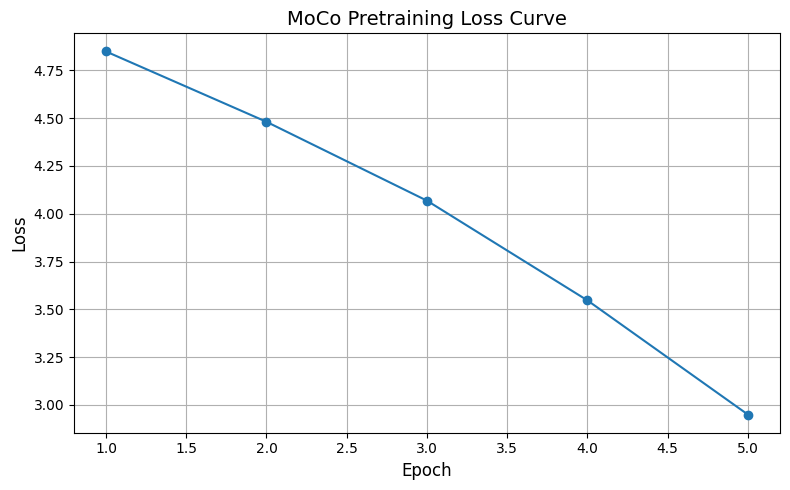

In [24]:
import os
import matplotlib.pyplot as plt



plt.figure(figsize=(8, 5))
plt.plot(range(1, len(losses) + 1), losses, marker='o')
plt.title("MoCo Pretraining Loss Curve", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


In [35]:
import os
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

# -----------------------------
# Configuration
# -----------------------------
data_dir = "/kaggle/input/leafdetection7/Niphad Grape Leaf Disease Dataset (NGLD) (2)/lebel/Niphad Grape Leaf Disease Dataset (NGLD)/Grapes Disease Dataset"
pretrained_path = "/kaggle/working/moco_forced_curve/encoder_q_backbone.pth"  # <-- MoCo checkpoint
num_epochs = 50
batch_size = 32
lr = 1e-4
image_size = 224
val_split = 0.2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------
# Transforms & Dataset
#   (use same norm as MoCo pretraining: mean=0.5, std=0.5)
# -----------------------------
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

full_dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=transform)
class_names = full_dataset.classes
num_classes = len(class_names)

# Train-val split
train_size = int((1.0 - val_split) * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# -----------------------------
# MoCo ResNet Encoder (load backbone weights)
# -----------------------------
class MoCoResNet50Encoder(nn.Module):
    def __init__(self, pretrained_path):
        super().__init__()
        resnet = torchvision.models.resnet50(pretrained=False)
        # Keep the backbone; we'll replace/ignore the fc later
        state = torch.load(pretrained_path, map_location="cpu")
        # This ckpt was saved from model.encoder_q (with a LinearHead). Load loosely:
        missing, unexpected = resnet.load_state_dict(state, strict=False)
        print("Loaded MoCo backbone. Missing keys:", missing, "| Unexpected keys:", unexpected)
        # Expose feature extractor without final fc
        resnet.fc = nn.Identity()
        self.backbone = resnet

    def forward(self, x):
        return self.backbone(x)

# -----------------------------
# Fine-Tuning Model
# -----------------------------
class FineTuneMoCo(nn.Module):
    def __init__(self, encoder, num_classes):
        super().__init__()
        self.encoder = encoder
        self.classifier = nn.Linear(2048, num_classes)

    def forward(self, x):
        feats = self.encoder(x)  # [B, 2048]
        return self.classifier(feats)

# Instantiate
encoder = MoCoResNet50Encoder(pretrained_path)
model = FineTuneMoCo(encoder, num_classes).to(device)

# -----------------------------
# Training Setup
# -----------------------------
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# -----------------------------
# Training Loop
# -----------------------------
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct_train, total_train = 0, 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)
        loop.set_postfix(loss=loss.item())

    avg_train_loss = total_loss / max(1, len(train_loader))
    train_losses.append(avg_train_loss)
    train_acc = correct_train / max(1, total_train)
    train_accuracies.append(train_acc)

    # -------------------------
    # Validation
    # -------------------------
    model.eval()
    correct_val, total_val = 0, 0
    val_loss_sum = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            vloss = criterion(outputs, labels)
            val_loss_sum += vloss.item()
            preds = outputs.argmax(dim=1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    avg_val_loss = val_loss_sum / max(1, len(val_loader))
    val_losses.append(avg_val_loss)
    val_acc = correct_val / max(1, total_val)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}: "
          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loaded MoCo backbone. Missing keys: ['fc.weight', 'fc.bias'] | Unexpected keys: ['fc.fc.weight', 'fc.fc.bias']


Epoch 1/50: 100%|██████████| 69/69 [00:23<00:00,  2.99it/s, loss=0.0749]


Epoch 1: Train Loss: 0.7071, Train Acc: 0.7353, Val Loss: 0.4923, Val Acc: 0.8700


Epoch 2/50: 100%|██████████| 69/69 [00:25<00:00,  2.76it/s, loss=0.416] 


Epoch 2: Train Loss: 0.3603, Train Acc: 0.8711, Val Loss: 0.6720, Val Acc: 0.8150


Epoch 3/50: 100%|██████████| 69/69 [00:24<00:00,  2.84it/s, loss=0.6]   


Epoch 3: Train Loss: 0.3080, Train Acc: 0.9005, Val Loss: 0.3613, Val Acc: 0.8626


Epoch 4/50: 100%|██████████| 69/69 [00:23<00:00,  2.94it/s, loss=0.203] 


Epoch 4: Train Loss: 0.2324, Train Acc: 0.9151, Val Loss: 0.5904, Val Acc: 0.8187


Epoch 5/50: 100%|██████████| 69/69 [00:24<00:00,  2.85it/s, loss=0.046] 


Epoch 5: Train Loss: 0.2204, Train Acc: 0.9220, Val Loss: 0.2619, Val Acc: 0.9212


Epoch 6/50: 100%|██████████| 69/69 [00:24<00:00,  2.83it/s, loss=0.491] 


Epoch 6: Train Loss: 0.1610, Train Acc: 0.9427, Val Loss: 0.2060, Val Acc: 0.9341


Epoch 7/50: 100%|██████████| 69/69 [00:23<00:00,  2.90it/s, loss=0.429] 


Epoch 7: Train Loss: 0.1599, Train Acc: 0.9436, Val Loss: 0.1499, Val Acc: 0.9579


Epoch 8/50: 100%|██████████| 69/69 [00:23<00:00,  2.88it/s, loss=0.33]  


Epoch 8: Train Loss: 0.1682, Train Acc: 0.9422, Val Loss: 0.2078, Val Acc: 0.9505


Epoch 9/50: 100%|██████████| 69/69 [00:24<00:00,  2.86it/s, loss=2.7]    


Epoch 9: Train Loss: 0.1417, Train Acc: 0.9665, Val Loss: 0.2513, Val Acc: 0.9267


Epoch 10/50: 100%|██████████| 69/69 [00:24<00:00,  2.87it/s, loss=2.39]  


Epoch 10: Train Loss: 0.1981, Train Acc: 0.9399, Val Loss: 0.3090, Val Acc: 0.8956


Epoch 11/50: 100%|██████████| 69/69 [00:23<00:00,  2.89it/s, loss=0.416] 


Epoch 11: Train Loss: 0.1849, Train Acc: 0.9349, Val Loss: 0.1812, Val Acc: 0.9469


Epoch 12/50: 100%|██████████| 69/69 [00:23<00:00,  2.90it/s, loss=0.0858] 


Epoch 12: Train Loss: 0.1221, Train Acc: 0.9610, Val Loss: 0.1141, Val Acc: 0.9707


Epoch 13/50: 100%|██████████| 69/69 [00:24<00:00,  2.87it/s, loss=0.0181] 


Epoch 13: Train Loss: 0.0682, Train Acc: 0.9780, Val Loss: 0.1135, Val Acc: 0.9670


Epoch 14/50: 100%|██████████| 69/69 [00:24<00:00,  2.86it/s, loss=2.62]   


Epoch 14: Train Loss: 0.1003, Train Acc: 0.9780, Val Loss: 0.1942, Val Acc: 0.9560


Epoch 15/50: 100%|██████████| 69/69 [00:23<00:00,  2.88it/s, loss=0.00584]


Epoch 15: Train Loss: 0.1289, Train Acc: 0.9514, Val Loss: 0.1460, Val Acc: 0.9542


Epoch 16/50: 100%|██████████| 69/69 [00:23<00:00,  2.89it/s, loss=0.486]  


Epoch 16: Train Loss: 0.0788, Train Acc: 0.9729, Val Loss: 0.1748, Val Acc: 0.9524


Epoch 17/50: 100%|██████████| 69/69 [00:23<00:00,  2.88it/s, loss=0.0153] 


Epoch 17: Train Loss: 0.0532, Train Acc: 0.9835, Val Loss: 0.1366, Val Acc: 0.9634


Epoch 18/50: 100%|██████████| 69/69 [00:23<00:00,  2.89it/s, loss=0.00479]


Epoch 18: Train Loss: 0.0313, Train Acc: 0.9894, Val Loss: 0.1181, Val Acc: 0.9780


Epoch 19/50: 100%|██████████| 69/69 [00:23<00:00,  2.89it/s, loss=0.00139] 


Epoch 19: Train Loss: 0.0322, Train Acc: 0.9908, Val Loss: 0.1153, Val Acc: 0.9744


Epoch 20/50: 100%|██████████| 69/69 [00:23<00:00,  2.89it/s, loss=0.0561]  


Epoch 20: Train Loss: 0.0270, Train Acc: 0.9890, Val Loss: 0.1740, Val Acc: 0.9597


Epoch 21/50: 100%|██████████| 69/69 [00:23<00:00,  2.90it/s, loss=0.000997]


Epoch 21: Train Loss: 0.0274, Train Acc: 0.9908, Val Loss: 0.2733, Val Acc: 0.9487


Epoch 22/50: 100%|██████████| 69/69 [00:23<00:00,  2.88it/s, loss=3.79]    


Epoch 22: Train Loss: 0.0855, Train Acc: 0.9876, Val Loss: 0.3178, Val Acc: 0.9231


Epoch 23/50: 100%|██████████| 69/69 [00:24<00:00,  2.86it/s, loss=1.09]  


Epoch 23: Train Loss: 0.2574, Train Acc: 0.9275, Val Loss: 0.2174, Val Acc: 0.9377


Epoch 24/50: 100%|██████████| 69/69 [00:24<00:00,  2.86it/s, loss=0.00264]


Epoch 24: Train Loss: 0.0835, Train Acc: 0.9697, Val Loss: 0.1443, Val Acc: 0.9542


Epoch 25/50: 100%|██████████| 69/69 [00:23<00:00,  2.89it/s, loss=0.881]  


Epoch 25: Train Loss: 0.0589, Train Acc: 0.9844, Val Loss: 0.1800, Val Acc: 0.9487


Epoch 26/50: 100%|██████████| 69/69 [00:23<00:00,  2.89it/s, loss=0.661]  


Epoch 26: Train Loss: 0.1007, Train Acc: 0.9670, Val Loss: 0.1796, Val Acc: 0.9615


Epoch 27/50: 100%|██████████| 69/69 [00:23<00:00,  2.88it/s, loss=1.76]    


Epoch 27: Train Loss: 0.1090, Train Acc: 0.9688, Val Loss: 0.2267, Val Acc: 0.9267


Epoch 28/50: 100%|██████████| 69/69 [00:24<00:00,  2.87it/s, loss=0.44]   


Epoch 28: Train Loss: 0.0990, Train Acc: 0.9674, Val Loss: 0.1283, Val Acc: 0.9634


Epoch 29/50: 100%|██████████| 69/69 [00:24<00:00,  2.87it/s, loss=0.0671] 


Epoch 29: Train Loss: 0.0533, Train Acc: 0.9821, Val Loss: 0.1344, Val Acc: 0.9689


Epoch 30/50: 100%|██████████| 69/69 [00:24<00:00,  2.86it/s, loss=1.53]   


Epoch 30: Train Loss: 0.0516, Train Acc: 0.9913, Val Loss: 0.1714, Val Acc: 0.9505


Epoch 31/50: 100%|██████████| 69/69 [00:24<00:00,  2.87it/s, loss=0.0212] 


Epoch 31: Train Loss: 0.0690, Train Acc: 0.9780, Val Loss: 0.1250, Val Acc: 0.9597


Epoch 32/50: 100%|██████████| 69/69 [00:24<00:00,  2.87it/s, loss=2.95]    


Epoch 32: Train Loss: 0.0643, Train Acc: 0.9922, Val Loss: 0.1580, Val Acc: 0.9524


Epoch 33/50: 100%|██████████| 69/69 [00:23<00:00,  2.88it/s, loss=0.178]  


Epoch 33: Train Loss: 0.0986, Train Acc: 0.9638, Val Loss: 0.1065, Val Acc: 0.9744


Epoch 34/50: 100%|██████████| 69/69 [00:24<00:00,  2.86it/s, loss=1.35]   


Epoch 34: Train Loss: 0.0514, Train Acc: 0.9876, Val Loss: 0.2114, Val Acc: 0.9451


Epoch 35/50: 100%|██████████| 69/69 [00:24<00:00,  2.87it/s, loss=0.807]  


Epoch 35: Train Loss: 0.1054, Train Acc: 0.9679, Val Loss: 0.1534, Val Acc: 0.9670


Epoch 36/50: 100%|██████████| 69/69 [00:23<00:00,  2.88it/s, loss=0.00274]


Epoch 36: Train Loss: 0.0464, Train Acc: 0.9830, Val Loss: 0.1683, Val Acc: 0.9560


Epoch 37/50: 100%|██████████| 69/69 [00:23<00:00,  2.88it/s, loss=0.00181] 


Epoch 37: Train Loss: 0.0295, Train Acc: 0.9894, Val Loss: 0.1276, Val Acc: 0.9670


Epoch 38/50: 100%|██████████| 69/69 [00:24<00:00,  2.86it/s, loss=0.194]   


Epoch 38: Train Loss: 0.0286, Train Acc: 0.9917, Val Loss: 0.1250, Val Acc: 0.9744


Epoch 39/50: 100%|██████████| 69/69 [00:24<00:00,  2.87it/s, loss=0.0302]  


Epoch 39: Train Loss: 0.0170, Train Acc: 0.9940, Val Loss: 0.1250, Val Acc: 0.9762


Epoch 40/50: 100%|██████████| 69/69 [00:24<00:00,  2.87it/s, loss=3.03e-5] 


Epoch 40: Train Loss: 0.0100, Train Acc: 0.9968, Val Loss: 0.1148, Val Acc: 0.9744


Epoch 41/50: 100%|██████████| 69/69 [00:24<00:00,  2.87it/s, loss=0.00438] 


Epoch 41: Train Loss: 0.0068, Train Acc: 0.9982, Val Loss: 0.1142, Val Acc: 0.9725


Epoch 42/50: 100%|██████████| 69/69 [00:23<00:00,  2.88it/s, loss=2.07]    


Epoch 42: Train Loss: 0.0468, Train Acc: 0.9936, Val Loss: 0.1303, Val Acc: 0.9670


Epoch 43/50: 100%|██████████| 69/69 [00:23<00:00,  2.88it/s, loss=0.278]  


Epoch 43: Train Loss: 0.1303, Train Acc: 0.9624, Val Loss: 0.1391, Val Acc: 0.9615


Epoch 44/50: 100%|██████████| 69/69 [00:24<00:00,  2.87it/s, loss=0.0739]  


Epoch 44: Train Loss: 0.0506, Train Acc: 0.9817, Val Loss: 0.1441, Val Acc: 0.9689


Epoch 45/50: 100%|██████████| 69/69 [00:24<00:00,  2.87it/s, loss=0.000306]


Epoch 45: Train Loss: 0.0186, Train Acc: 0.9940, Val Loss: 0.1345, Val Acc: 0.9670


Epoch 46/50: 100%|██████████| 69/69 [00:24<00:00,  2.86it/s, loss=0.00011] 


Epoch 46: Train Loss: 0.0069, Train Acc: 0.9991, Val Loss: 0.1622, Val Acc: 0.9652


Epoch 47/50: 100%|██████████| 69/69 [00:23<00:00,  2.88it/s, loss=0.000307]


Epoch 47: Train Loss: 0.0038, Train Acc: 0.9995, Val Loss: 0.1473, Val Acc: 0.9744


Epoch 48/50: 100%|██████████| 69/69 [00:23<00:00,  2.88it/s, loss=0.282]   


Epoch 48: Train Loss: 0.0056, Train Acc: 0.9995, Val Loss: 0.1368, Val Acc: 0.9744


Epoch 49/50: 100%|██████████| 69/69 [00:23<00:00,  2.90it/s, loss=1.71]    


Epoch 49: Train Loss: 0.0702, Train Acc: 0.9849, Val Loss: 0.2347, Val Acc: 0.9432


Epoch 50/50: 100%|██████████| 69/69 [00:23<00:00,  2.90it/s, loss=0.000828]


Epoch 50: Train Loss: 0.1443, Train Acc: 0.9528, Val Loss: 0.1799, Val Acc: 0.9615


In [36]:
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Train Accuracy: {train_acc:.4f}")

Validation Accuracy: 0.9615
Train Accuracy: 0.9528


In [37]:
# -----------------------------
# Save the fine-tuned model
# -----------------------------
model_path = "/kaggle/working/fine_tuned_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")


Model saved to /kaggle/working/fine_tuned_model.pth


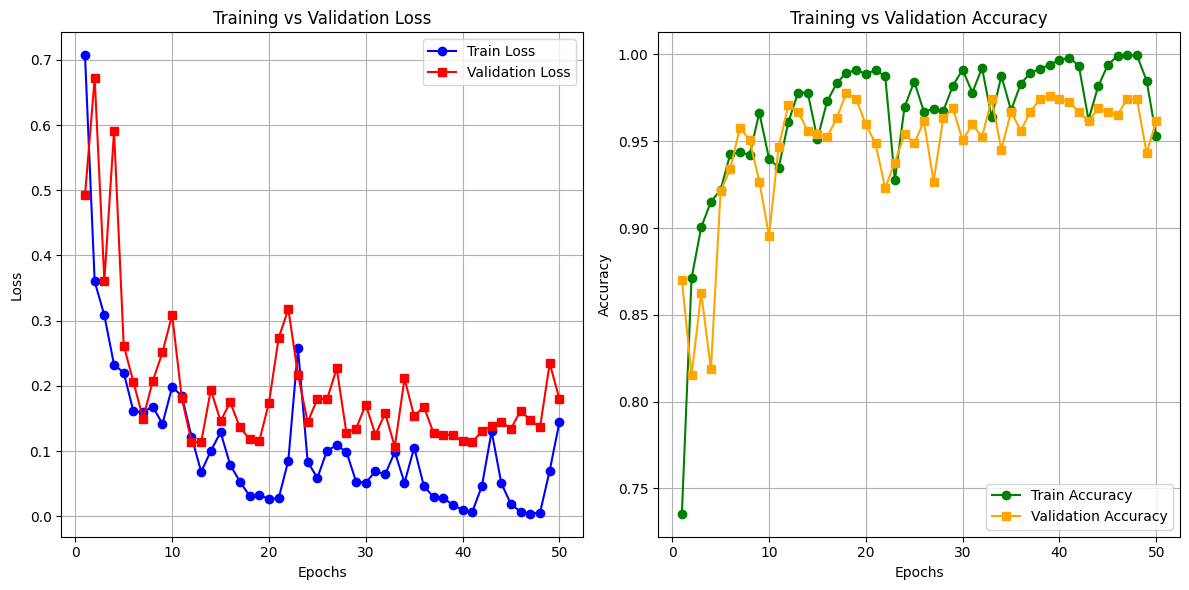

In [38]:
# -----------------------------
# Plotting Loss & Accuracy Curves
# -----------------------------
import matplotlib.pyplot as plt

def plot_loss_accuracy(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 6))

    # Loss Curve
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', color='blue', marker='o')
    plt.plot(epochs, val_losses, label='Validation Loss', color='red', marker='s')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(True)

    # Accuracy Curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy', color='green', marker='o')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='orange', marker='s')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig("loss_accuracy_curves.png", dpi=300)
    plt.show()

# -----------------------------
# Call after training finishes
# -----------------------------
plot_loss_accuracy(train_losses, val_losses, train_accuracies, val_accuracies)



AUC (per class):
  Bacterial Leaf Spot      : 0.9979
  Downy Mildew             : 0.9944
  Healthy Leaves           : 0.9917
  Powdery Mildew           : 0.9810
Micro-average AUC: 0.9933
Macro-average AUC: 0.9917


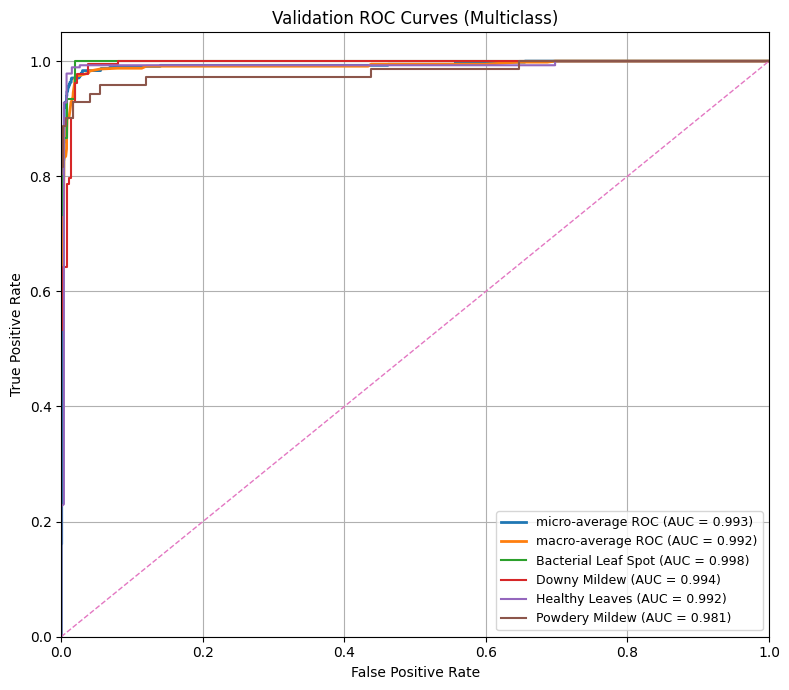

In [39]:
# =============================
# ROC / AUC on validation set
# =============================
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score

model.eval()
y_true_list = []
y_score_list = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        logits = model(images)
        probs = torch.softmax(logits, dim=1)  # [B, num_classes]

        y_true_list.append(labels.detach().cpu().numpy())
        y_score_list.append(probs.detach().cpu().numpy())

y_true = np.concatenate(y_true_list, axis=0)          # shape [N]
y_score = np.concatenate(y_score_list, axis=0)        # shape [N, C]

# Binarize labels for one-vs-rest ROC
classes = list(range(num_classes))
y_bin = label_binarize(y_true, classes=classes)       # shape [N, C]

# Per-class ROC & AUC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in classes:
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average
fpr["micro"], tpr["micro"], _ = roc_curve(y_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Macro-average
# Aggregate all FPRs
all_fpr = np.unique(np.concatenate([fpr[i] for i in classes]))
# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in classes:
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= len(classes)
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Print AUCs
print("\nAUC (per class):")
for i, name in enumerate(class_names):
    print(f"  {name:25s}: {roc_auc[i]:.4f}")
print(f"Micro-average AUC: {roc_auc['micro']:.4f}")
print(f"Macro-average AUC: {roc_auc['macro']:.4f}")

# Plot ROC curves
plt.figure(figsize=(8, 7))
# Micro & Macro first
plt.plot(fpr["micro"], tpr["micro"], label=f"micro-average ROC (AUC = {roc_auc['micro']:.3f})", linewidth=2)
plt.plot(fpr["macro"], tpr["macro"], label=f"macro-average ROC (AUC = {roc_auc['macro']:.3f})", linewidth=2)

# Per-class curves
for i, name in enumerate(class_names):
    plt.plot(fpr[i], tpr[i], label=f"{name} (AUC = {roc_auc[i]:.3f})")

plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1)  # chance line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Validation ROC Curves (Multiclass)")
plt.legend(loc="lower right", fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.savefig("roc_auc_val.png", dpi=300)
plt.show()


Classification Report:

                     precision    recall  f1-score   support

Bacterial Leaf Spot     0.9231    0.8000    0.8571        15
       Downy Mildew     0.9613    0.9560    0.9587       182
     Healthy Leaves     0.9617    0.9928    0.9770       278
     Powdery Mildew     0.9692    0.8873    0.9265        71

           accuracy                         0.9615       546
          macro avg     0.9538    0.9090    0.9298       546
       weighted avg     0.9615    0.9615    0.9610       546



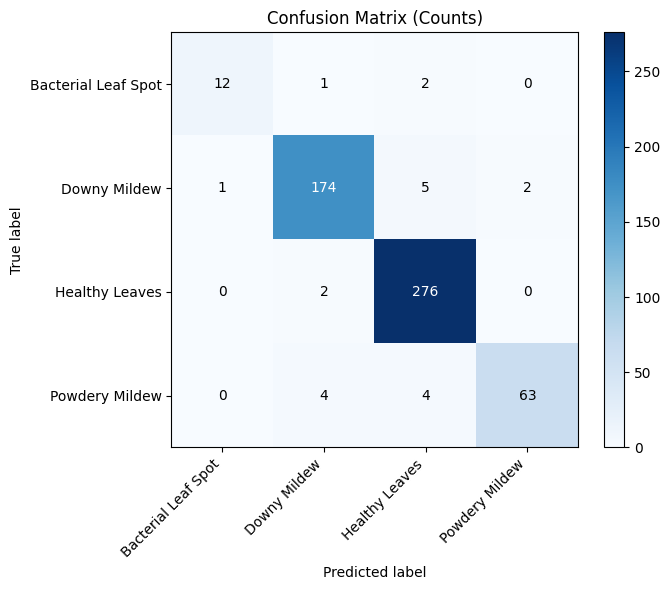

In [40]:
# =============================
# Confusion Matrix (Sky Blue)
# =============================
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        logits = model(images)
        preds = logits.argmax(dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred, labels=list(range(len(class_names))))

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# ---------- Sky Blue Plot ----------
plt.figure(figsize=(7, 6))
im = plt.imshow(cm, interpolation='nearest', cmap='Blues', aspect='auto')  # Sky blue tones
plt.title("Confusion Matrix (Counts)")
plt.colorbar(im)
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45, ha="right")
plt.yticks(tick_marks, class_names)

fmt = "d"
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], fmt),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.savefig("confusion_matrix_val.png", dpi=300)
plt.show()




Test classes: ['Bacterial Leaf Spot', 'Downy Mildew', 'Healthy Leaves', 'Powdery Mildew'] | count: 4
[Remap] loaded 320 keys
[Remap] missing: []
[Remap] unexpected: []

✅ Test Accuracy (overall): 97.80%

Classification Report:
                     precision    recall  f1-score   support

Bacterial Leaf Spot       1.00      0.93      0.97        15
       Downy Mildew       0.99      0.97      0.98       145
     Healthy Leaves       0.96      0.99      0.98       188
     Powdery Mildew       0.98      0.95      0.97        61

           accuracy                           0.98       409
          macro avg       0.98      0.96      0.97       409
       weighted avg       0.98      0.98      0.98       409

Confusion Matrix (raw counts):
 [[ 14   0   1   0]
 [  0 141   3   1]
 [  0   1 187   0]
 [  0   0   3  58]]


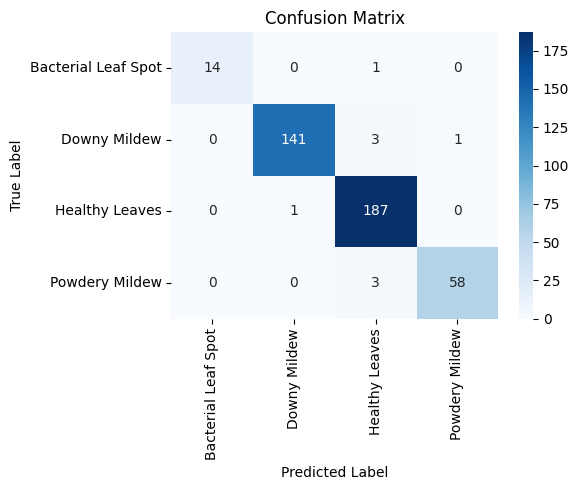

In [65]:
import os, torch, torch.nn as nn, torch.nn.functional as F
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ===== Paths =====
FINETUNE_CKPT = "/kaggle/working/fine_tuned_model.pth"   # your saved fine-tuned state_dict
TEST_DIR      = "/kaggle/input/test7777/Niphad Grape Leaf Disease Dataset (NGLD)/Grapes Disease Dataset test"

# ===== Data =====
IMG_SIZE, BATCH_SIZE, NUM_WORKERS = 224, 32, 2
test_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])
test_ds = datasets.ImageFolder(TEST_DIR, transform=test_tfms)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=NUM_WORKERS, pin_memory=True)
print("Test classes:", test_ds.classes, "| count:", len(test_ds.classes))

# ===== Model =====
def build_resnet50_classifier(num_classes: int):
    m = models.resnet50(weights=None)
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    return m

def load_ft_ckpt_with_remap(model: nn.Module, ckpt_path: str):
    sd = torch.load(ckpt_path, map_location="cpu")
    # Some saves wrap in {"state_dict": ...}
    if isinstance(sd, dict) and "state_dict" in sd:
        sd = sd["state_dict"]

    remapped = {}
    for k, v in sd.items():
        k = k.replace("module.", "")  # strip DP
        if k.startswith("encoder.backbone."):
            new_k = k.replace("encoder.backbone.", "")      # -> resnet keys
        elif k.startswith("classifier."):
            new_k = "fc." + k[len("classifier."):]          # -> fc.*
        else:
            # ignore anything not backbone/classifier (e.g., EMA, queue, etc.)
            continue
        remapped[new_k] = v

    missing, unexpected = model.load_state_dict(remapped, strict=False)
    print(f"[Remap] loaded {len(remapped)} keys")
    print(f"[Remap] missing: {missing}")
    print(f"[Remap] unexpected: {unexpected}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Use the number of classes your model was trained on (likely 4).
# If you're not sure, inspect FINETUNE_CKPT['classifier.weight'].shape[0].
trained_num_classes = 4  # <-- change if your fine-tuned head was different

model = build_resnet50_classifier(trained_num_classes).to(device)
load_ft_ckpt_with_remap(model, FINETUNE_CKPT)
model.eval()

# ===== Safety check for class mismatch =====
if trained_num_classes != len(test_ds.classes):
    print(f"⚠️ Mismatch: model expects {trained_num_classes} classes "
          f"but test set has {len(test_ds.classes)} folders: {test_ds.classes}")
    print("→ Point TEST_DIR to the correct 4-class test set, or fine-tune a 3-class model before evaluating.")
    # We’ll still compute *overall accuracy* so you can sanity-check the pipeline:
    compute_report = False
else:
    compute_report = True

# ===== Evaluate =====
y_true, y_pred = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        logits = model(imgs)
        preds = torch.argmax(F.softmax(logits, dim=1), dim=1)
        y_true.extend(labels.cpu().tolist())
        y_pred.extend(preds.cpu().tolist())

acc = accuracy_score(y_true, y_pred)
print(f"\n✅ Test Accuracy (overall): {acc*100:.2f}%")

# Only print per-class report if counts match
if compute_report:
    from sklearn.metrics import classification_report, confusion_matrix
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=test_ds.classes))
   
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix (raw counts):\n", cm)

# ---- Optional: nicer plot ----
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_ds.classes if len(test_ds.classes) == cm.shape[0] else np.arange(cm.shape[0]),
            yticklabels=test_ds.classes if len(test_ds.classes) == cm.shape[0] else np.arange(cm.shape[0]))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


